In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:23: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 10

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models

"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 21s 796us/step - accuracy: 0.5117 - loss: 0.2503 - val_accuracy: 0.5323 - val_loss: 0.2485
Epoch 2/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 657us/step - accuracy: 0.5284 - loss: 0.2487 - val_accuracy: 0.5388 - val_loss: 0.2477
Epoch 3/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 680us/step - accuracy: 0.5368 - loss: 0.2479 - val_accuracy: 0.5412 - val_loss: 0.2474
Epoch 4/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 650us/step - accuracy: 0.5430 - loss: 0.2472 - val_accuracy: 0.5471 - val_loss: 0.2462
Epoch 5/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 655us/step - accuracy: 0.5462 - loss: 0.2464 - val_accuracy: 0.5532 - val_loss: 0.2455
Epoch 6/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step - accuracy: 0.5514 - loss: 0.2456 - val_accuracy: 0.5572 - val_loss: 0.2445
Epoch 7/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 669us/step - accuracy: 0.5524 - loss: 0.2452 - val_accuracy: 0.5608 - val_loss: 0.2439
Epoch 8/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 664us/step - accuracy: 0.5578 

In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 2s 400us/step
Ridge Classifier:
Accuracy: 0.5155106630994624
Confusion Matrix:
[[78919 20353]
 [73995 21470]]
Precision: 51.335389618152696
Recall: 22.489917770910807
F1 Score: 31.277314841792435
MSE: 48.448933690053764
RMSE: 69.60526825611245


XGBoost Classifier:
Accuracy: 0.5136363402948593
Confusion Matrix:
[[52887 46385]
 [48328 47137]]
Precision: 50.40204443874169
Recall: 49.3762111768711
F1 Score: 49.883854445014734
MSE: 48.63636597051408
RMSE: 69.73977772441928


LightGBM Classifier:
Accuracy: 0.5177906612508152
Confusion Matrix:
[[55333 43939]
 [49965 45500]]
Precision: 50.872661814197386
Recall: 47.66144660346724
F1 Score: 49.2147276424523
MSE: 48.22093387491848
RMSE: 69.44129454072589


Neural Network:
Accuracy: 0.5052660768112891
Confusion Matrix:
[[56577 42695]
 [53648 41817]]
Precision: 49.48054714123438
Recall: 4

In [8]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [9]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [10]:
def calculate_annualized_volatility(df, window=252):
    """Calculate the rolling annualized volatility for each asset in the dataframe."""
    volatilities = df.copy()
    volatilities.fillna(0, inplace=True)


    return volatilities.rolling(window=window).std() * np.sqrt(window)

volatilities = calculate_annualized_volatility(df_read)


In [11]:


"""def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)"""


"def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):\n\n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        \n        # Normalization factor to ensure absolute sum of values is 1\n        num_assets = len(assets)\n        if num_assets > 0:\n            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets\n\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\n\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test

In [12]:


def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days, volatilities):
    """Update df by marking assets in portfolios with inverse volatility weighted values 
    starting two days after for a duration, such that the absolute sum of values is 1."""
    
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)
        end_date = start_date + pd.DateOffset(days=hold_days - 1)

        if start_date in volatilities.index:
            if portfolio_type == 'best':
                # Get volatilities for the assets at the start date
                asset_vols = volatilities.loc[start_date, assets].dropna()
                if not asset_vols.empty:
                    weights = 1 / asset_vols
                    total_weight = weights.sum()
                    normalized_weights = weights / total_weight  # Normalize weights

                    # Assign weights to assets in the DataFrame
                    for asset, weight in normalized_weights.items():
                        if asset in df.columns:
                            df.loc[start_date:end_date, asset] = weight
            else:
                num_assets = len(assets)
                if num_assets > 0:
                    value = -1 / num_assets
                    for asset in assets:
                        if asset in df.columns:
                            df.loc[start_date:end_date, asset] = value




portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

   
    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days, volatilities)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days, volatilities)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_3172\432903135.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.44790427846710706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = weight
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_3172\432903135.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5520957215328929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = weight
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_3172\432903135.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.023445494334981127' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start

6086/6086 ━━━━━━━━━━━━━━━━━━━━ 2s 401us/step


C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_3172\432903135.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4560225732980204' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = weight
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_3172\432903135.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5439774267019797' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_date:end_date, asset] = weight
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_3172\432903135.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.03814583665745893' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_d

In [13]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']
NN_weights = model_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


In [14]:


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)



In [15]:
xgb_trade_volume.sum()

33740

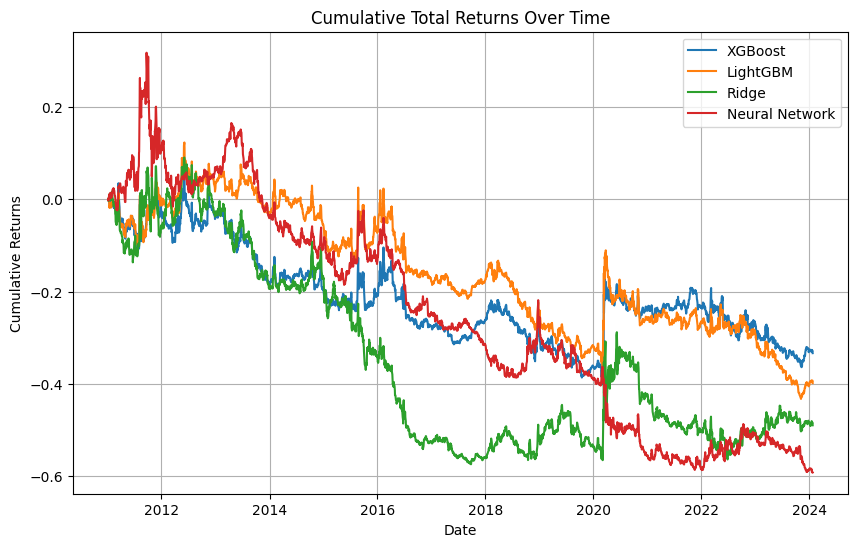

In [16]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [17]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
33740


LightGBM trade volume:
32587


Ridge trade volume:
34626


Neural Network trade volume:
33697




In [18]:
ridge_metrics = financial_metrics(ridge_total_returns)
lgb_metrics = financial_metrics(lgb_total_returns)
xgb_metrics = financial_metrics(xgb_total_returns)
NN_metrics = financial_metrics(NN_total_returns)

In [19]:
print("Ridge metrics:")
print(ridge_metrics)
print("\n")
print("LightGBM metrics:")
print(lgb_metrics)
print("\n")
print("XGBoost metrics:")
print(xgb_metrics)
print("\n")
print("Neural Network metrics:")
print(NN_metrics)


Ridge metrics:
{'Average Yearly Return': -0.03311892197676517, 'Average Yearly Standard Deviation': 0.187423896223584, 'Sharpe Ratio': -0.17670597316607134, 'Max Drawdown': -8.929855920276147, 'Volatility': 0.187423896223584, 'Calmar Ratio': -0.0037087857040968924, 'Skewness': 1.2373361981251139, 'Kurtosis': 33.23926440115732}


LightGBM metrics:
{'Average Yearly Return': -0.0307754372331427, 'Average Yearly Standard Deviation': 0.12226174337961207, 'Sharpe Ratio': -0.25171763776987577, 'Max Drawdown': -7.96060287576172, 'Volatility': 0.12226174337961207, 'Calmar Ratio': -0.003865968157618705, 'Skewness': 2.306184449246648, 'Kurtosis': 35.39544280365372}


XGBoost metrics:
{'Average Yearly Return': -0.022610668634444102, 'Average Yearly Standard Deviation': 0.12601582575737313, 'Sharpe Ratio': -0.17942721478473636, 'Max Drawdown': -8.242700678507205, 'Volatility': 0.12601582575737313, 'Calmar Ratio': -0.0027431141219771927, 'Skewness': 2.165515607142032, 'Kurtosis': 36.2804408792761}



In [24]:

def calculate_momentum(df, windows=[63, 126, 252]):
    """ Calculate momentum for specified windows and average them. """
    momentum_df = pd.DataFrame(index=df.index)
    for window in windows:
        rolled = df.rolling(window=window, min_periods=1).mean()  # Using mean as a placeholder for any momentum calculation
        momentum_df[f'momentum_{window}'] = rolled.mean(axis=1)  # Mean across assets, adjust as necessary
    momentum_df['avg_momentum'] = momentum_df.mean(axis=1, skipna=True)
    return momentum_df

def rank_and_allocate(momentum_df, top_n=0.2, bottom_n=0.2):
    """ Rank assets based on their momentum and allocate long/short positions. """
    num_assets = len(momentum_df.columns)
    ranks = momentum_df['avg_momentum'].rank(ascending=False)

    long_positions = ranks <= (num_assets * top_n)
    short_positions = ranks > (num_assets * (1 - bottom_n))

    weights = pd.Series(index=momentum_df.index, dtype=float)
    total_long = long_positions.sum()
    total_short = short_positions.sum()

    weights[long_positions] = 1.0 / total_long if total_long > 0 else 0
    weights[short_positions] = -1.0 / total_short if total_short > 0 else 0

    return weights


def create_benchmark_portfolio(df, hold_days=252):
    """ Create a benchmark portfolio based on momentum. """
    momentum_df = calculate_momentum(df)  # Your existing function to calculate momentum
    portfolio_weights = pd.DataFrame(0, index=df.index, columns=df.columns)  # Initialize weights DataFrame

    for start_date in df.index:
        end_date = start_date + pd.DateOffset(days=hold_days - 1)
        if end_date > df.index[-1]:  # Ensure end_date is within the DataFrame's range
            continue

        current_momentum = momentum_df.loc[start_date:end_date]
        weights = rank_and_allocate(current_momentum)  # Your function to calculate weights based on rankings

        # Ensure weights array length matches the slice length
        date_range = pd.date_range(start_date, end_date)
        if len(weights) == len(date_range):
            portfolio_weights.loc[date_range] = weights.values[:, None]  # Broadcasting weights across all asset columns
        

    # Zero out any MACRO related weights to ensure they do not influence the portfolio
    macro_columns = [col for col in df.columns if 'MACRO' in col]
    portfolio_weights[macro_columns] = 0

    return portfolio_weights


In [26]:
# Assuming `df_read` is your DataFrame with asset returns
benchmark_portfolio = create_benchmark_portfolio(df_read, hold_days=10)
benchmark_portfolio.tail(50)



,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-11-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
benchmark_portfolio.sum(axis=1)

todate
1980-01-02    0
1980-01-03    0
1980-01-04    0
1980-01-07    0
1980-01-08    0
1980-01-09    0
1980-01-10    0
1980-01-11    0
1980-01-14    0
1980-01-15    0
1980-01-16    0
1980-01-17    0
1980-01-18    0
1980-01-21    0
1980-01-22    0
1980-01-23    0
1980-01-24    0
1980-01-25    0
1980-01-28    0
1980-01-29    0
1980-01-30    0
1980-01-31    0
1980-02-01    0
1980-02-04    0
1980-02-05    0
1980-02-06    0
1980-02-07    0
1980-02-08    0
1980-02-11    0
1980-02-12    0
1980-02-13    0
1980-02-14    0
1980-02-15    0
1980-02-18    0
1980-02-19    0
1980-02-20    0
1980-02-21    0
1980-02-22    0
1980-02-25    0
1980-02-26    0
1980-02-27    0
1980-02-28    0
1980-02-29    0
1980-03-03    0
1980-03-04    0
1980-03-05    0
1980-03-06    0
1980-03-07    0
1980-03-10    0
1980-03-11    0
1980-03-12    0
1980-03-13    0
1980-03-14    0
1980-03-17    0
1980-03-18    0
1980-03-19    0
1980-03-20    0
1980-03-21    0
1980-03-24    0
1980-03-25    0
1980-03-26    0
1980-03-27    0
1

In [28]:
def calculate_momentum(df):
    # Example placeholder logic for momentum
    return df.pct_change(252).fillna(0)  # Using 252-day percentage change as a placeholder

momentum_df = calculate_momentum(df_read)
momentum_df.tail(50)

C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_3172\2633577464.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df.pct_change(252).fillna(0)  # Using 252-day percentage change as a placeholder


,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-15,-1.473435,-1.117448,-1.818494,-3.703067,-2.917617,-1.042024,-1.218576,-2.383110,-1.090413,-0.305256,-1.432687,-2.508619,-1.755850,-4.538472,-1.887594,-6.245298,2.042460,-1.315970,-1.031359,-1.197350,-1.112412,-0.919522,-3.400291,-0.619938,-1.056848,-1.206647,-1.071475,-1.338502,0.285628,-1.870253,18.437393,-2.050519,-0.885680,11.952968,0.339907,-2.436716,2.682780,-50.444065,10.478165,13.046608,3.606200e+04,-9.872143,1.209470,-1.015818,-0.446433,-1.124212,-0.488774,-0.494460,-4.870977,-1.451970,-1.175065,-1.310935,-1.098602,-0.940022,2.058018,-1.591062,-2.016142,-0.152673,-2.490064,-0.853600,-2.616127,-4.349035,-0.791186,-5.450576,-1.483168,-2.848146,-0.013212
2023-11-16,-12.766415,-1.425318,-1.594379,-1.289663,-1.506332,-1.065640,-0.441114,1.587885,-6.954276,-0.480019,-10.949177,-1.067454,2.417858,-3.469250,-1.295447,-2.892892,2.294429,-0.537596,-2.296793,-0.362900,-1.046658,-2.385977,1.939940,-1.623015,-1.479064,2.042693,-1.017018,-11.221830,-2.175157,-0.372528,-5.012054,22.541222,-0.117979,-1.341616,-0.354033,-0.340835,-0.372201,-12.775026,-3.513497,-2.635834,-3.018912e+00,-2.207246,-0.781509,-2.001430,-0.037196,-0.173685,-1.240826,-1.634973,1.758688,-8.723521,-2.402678,0.775212,-0.850796,-1.044711,-0.101286,-1.924349,-1.092072,0.220407,-8.483397,1.446050,-4.952341,-26.941502,-2.241099,-9.156371,-0.815312,-1.699332,-14.097084
2023-11-17,-0.131413,-0.968330,0.942713,-2.304561,-0.962667,-1.002506,-0.087960,1.414961,-0.518705,0.037703,0.203801,-9.188154,0.088792,-1.209946,-1.537236,0.292654,-1.108325,-0.674515,-1.108203,-0.932865,-0.629367,3.500020,-1.131739,-0.895716,-1.053688,-0.833467,-1.100225,-1.023175,-0.847873,-0.646659,-1.352816,-1.071556,-0.631433,-7.814184,-0.380129,-0.486122,-0.655571,-1.602169,-1.220772,-0.700115,-1.000126e+00,-2.250784,0.115056,-0.612051,-0.717532,-0.723884,-0.485923,-0.509430,0.315043,-0.383946,-0.920410,-0.367690,-0.640267,-1.498828,-1.134541,-0.955219,-1.907437,-1.124829,-0.207835,-0.393468,0.361408,1.181321,-1.096161,1.675667,-1.072290,-5.983170,-1.276547
2023-11-20,-0.339027,61.414386,-1.170709,0.636348,-0.999972,6.013163,0.238085,-0.804741,-3.663302,-1.015768,3.697359,6.373392,-0.608760,-0.890894,-0.207826,-0.795140,-1.974465,-1.551063,2.025559,0.798686,inf,-1.549079,-1.028388,2.443703,6.260110,-8.657425,-3.761910,1.168117,-0.814481,-1.442208,-0.929835,-1.315319,-0.977434,-0.591590,-1.177812,-1.319414,-1.251415,-1.030699,-0.911410,-0.819760,-9.017431e-01,-0.866670,-1.786577,0.932810,-0.697904,-1.464178,-0.597671,-0.576665,-0.546394,0.012074,-0.331967,-0.519770,-0.857794,1.275331,0.091038,-1.067526,-1.834238,-1.877177,-0.045899,-1.070452,1.864754,8.370805,4.242156,-2.482956,-25.857970,-2.107587,-0.159941
2023-11-21,0.435388,0.575330,-1.071004,-0.349059,-2.768920,0.375884,1.206868,-3.006821,-3.294624,-2.457302,4.209764,-0.917987,-inf,-1.446423,-1.881487,-7.217806,-1.679705,-0.865560,1.095152,-0.645569,-1.157602,-0.458379,-0.343882,-1.402340,0.474705,1.025703,0.079390,-1.989652,-1.086222,-1.508898,1.837552,-1.952943,-1.352964,-16.976664,-1.999691,-1.861530,-2.165843,-2.013796,1.105470,-1.746872,-7.510087e-01,-1.125757,-0.345170,-0.453461,0.050048,-1.661421,-1.706597,-2.896200,-1.059631,-1.479061,-0.430299,0.518691,-1.493632,0.732450,-0.573909,-9.440894,-2.162788,-1.512194,-0.815479,-4.484352,-0.949638,-2.380317,-0.738278,5.972968,-1.942363,-0.200844,-1.756771
2023-11-22,-1.649591,-1.196197,-1.829426,-1.000000,-0.822495,-1.214453,-0.976575,0.051330,-1.202326,-9.723006,-0.770623,-3.462198,-2.216480,-1.294929,-1.385896,-